<a href="https://colab.research.google.com/github/Poohi5/cmpe257/blob/master/HW2/Clustering_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
url = 'https://raw.githubusercontent.com/Poohi5/cmpe257/master/HW1/AQ_Boston_Cam-Quincy%20(1).csv'
df = pd.read_csv(url)
df.head(5)

,['location','city','country','utc','local','parameter','value','unit','latitude','longitude','attribution'],Unnamed: 11,Unnamed: 12
0,['Portsmouth','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','o3','0.035','ppm','43.075371','-70.748017',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
1,['Odiorne State Park','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','o3','0.038','ppm','43.045269','-70.713958',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
2,['Portsmouth','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','pm10','10','µg/m³','43.075371','-70.748017',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
3,['Portsmouth','Boston-Cambridge-Quincy','US','2020-02-09T18:00:00.000Z','2020-02-09T13:00:00-05:00','pm25','4.8','µg/m³','43.075371','-70.748017',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""New Hampshire Dept. of Environmental ..."
4,['LYNN','Boston-Cambridge-Quincy','US','2020-02-09T17:00:00.000Z','2020-02-09T12:00:00-05:00','no2','0.008','ppm','42.474701','-70.971901',"'[{""name"":""US EPA AirNow""","url:""http://www.airnow.gov/""}","{""name"":""Massachusetts Dept. of Environmental ..."


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.mixture import GaussianMixture

In [23]:
df.dtypes

['location'        object
 'city'            object
 'country'         object
 'utc'             object
 'local'           object
 'parameter'       object
 'value'           object
 'unit'            object
 'latitude'        object
 'longitude'       object
 'attribution']    object
Unnamed: 11        object
Unnamed: 12        object
dtype: object

In [4]:
df = df.apply(lambda s:s.str.replace('\'', "").str.replace('[', ""))
df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '').str.replace('\'','')
df.drop(df.columns[[10,11,12]], axis=1, inplace=True)
df.head(5)

,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.035,ppm,43.075371,-70.748017
1,Odiorne State Park,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.038,ppm,43.045269,-70.713958
2,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm10,10,µg/m³,43.075371,-70.748017
3,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm25,4.8,µg/m³,43.075371,-70.748017
4,LYNN,Boston-Cambridge-Quincy,US,2020-02-09T17:00:00.000Z,2020-02-09T12:00:00-05:00,no2,0.008,ppm,42.474701,-70.971901


##Data Cleaning

In [0]:
c = df['location'].astype('category')
d = dict(enumerate(c.cat.categories))
df['location'] = c.cat.codes

In [0]:
import datetime
df['date'] = pd.DatetimeIndex(df['local']).date

In [7]:
df.head()

,location,city,country,utc,local,parameter,value,unit,latitude,longitude,date
0,7,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.035,ppm,43.075371,-70.748017,2020-02-09
1,6,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.038,ppm,43.045269,-70.713958,2020-02-09
2,7,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm10,10,µg/m³,43.075371,-70.748017,2020-02-09
3,7,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm25,4.8,µg/m³,43.075371,-70.748017,2020-02-09
4,5,Boston-Cambridge-Quincy,US,2020-02-09T17:00:00.000Z,2020-02-09T12:00:00-05:00,no2,0.008,ppm,42.474701,-70.971901,2020-02-09


###Feature Computation

In [8]:
dfnew = df[(df['location'] == 7)]
print(dfnew)

      location                      city  ...    longitude        date
0            7   Boston-Cambridge-Quincy  ...   -70.748017  2020-02-09
2            7   Boston-Cambridge-Quincy  ...   -70.748017  2020-02-09
3            7   Boston-Cambridge-Quincy  ...   -70.748017  2020-02-09
9            7   Boston-Cambridge-Quincy  ...   -70.748017  2020-02-09
11           7   Boston-Cambridge-Quincy  ...   -70.748017  2020-02-09
...        ...                       ...  ...          ...         ...
9977         7   Boston-Cambridge-Quincy  ...   -70.748017  2020-01-18
9978         7   Boston-Cambridge-Quincy  ...   -70.748017  2020-01-18
9986         7   Boston-Cambridge-Quincy  ...   -70.748017  2020-01-17
9987         7   Boston-Cambridge-Quincy  ...   -70.748017  2020-01-17
9995         7   Boston-Cambridge-Quincy  ...   -70.748017  2020-01-17

[2139 rows x 11 columns]


##Pivoting Table

In [9]:
table = pd.pivot_table(dfnew, values='value', index=['location', 'local', 'date'], columns=['parameter'], aggfunc=np.sum, fill_value=0)
table.reset_index(inplace=True)
table.columns = table.columns.str.strip()

def covert_to_float(param):
  try:
      table[param] =  table[param].astype(float)
  except (KeyError):
      pass
    
arr = ['co','no2','o3','so2','pm10','pm25']
for i in arr:
    covert_to_float(i)
table.tail(5)

parameter,location,local,date,o3,pm10,pm25,so2
536,7,2020-02-09T09:00:00-05:00,2020-02-09,0.000,71.0,13.8,0.006
537,7,2020-02-09T10:00:00-05:00,2020-02-09,0.034,66.0,13.0,0.004
538,7,2020-02-09T11:00:00-05:00,2020-02-09,0.036,30.0,6.8,0.004
539,7,2020-02-09T12:00:00-05:00,2020-02-09,0.035,16.0,5.3,0.003
540,7,2020-02-09T13:00:00-05:00,2020-02-09,0.035,10.0,4.8,0.000


In [10]:
AQI_table = table.groupby(table['date']).mean()
AQI_table.reset_index(inplace=True)
AQI_table.head(5)

parameter,date,location,o3,pm10,pm25,so2
0,2020-01-17,7,0.032000,0.000000,4.600000,0.002000
1,2020-01-18,7,0.031208,11.416667,5.783333,0.002083
2,2020-01-19,7,0.024375,12.958333,6.500000,0.002125
3,2020-01-20,7,0.030208,14.916667,4.750000,0.001958
4,2020-01-21,7,0.028000,17.250000,6.166667,0.002417


#AQI Calculation

In [0]:
import aqi

def cal_PM10aqi(value):
  PM10_aqi = aqi.to_iaqi(aqi.POLLUTANT_PM10, str(value))
  return PM10_aqi

In [0]:
def cal_PM25aqi(value):
  PM25_aqi = aqi.to_iaqi(aqi.POLLUTANT_PM25, str(value))
  return PM25_aqi

In [13]:
AQI_table['PM10_aqi'] = AQI_table.apply(lambda idx: cal_PM10aqi(idx['pm10']), axis=1)
AQI_table['PM25_aqi'] = AQI_table.apply(lambda idx: cal_PM25aqi(idx['pm25']), axis=1)
AQI_table

parameter,date,location,o3,pm10,pm25,so2,PM10_aqi,PM25_aqi
0,2020-01-17,7,0.032000,0.000000,4.600000,0.002000,0,19
1,2020-01-18,7,0.031208,11.416667,5.783333,0.002083,10,24
2,2020-01-19,7,0.024375,12.958333,6.500000,0.002125,11,27
3,2020-01-20,7,0.030208,14.916667,4.750000,0.001958,13,20
4,2020-01-21,7,0.028000,17.250000,6.166667,0.002417,16,25
5,2020-01-22,7,0.022250,18.333333,9.795833,0.002250,17,40
6,2020-01-23,7,0.012545,35.136364,15.618182,0.002136,32,58
7,2020-01-24,7,0.022583,24.375000,13.500000,0.001917,22,54
8,2020-01-25,7,0.036375,15.166667,7.858333,0.001833,14,32
9,2020-01-26,7,0.025583,5.666667,3.441667,0.001167,5,14


##K-Means

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(AQI_table[['PM10_aqi', 'pm25','pm10','PM25_aqi','o3']])
AQI_table['cluster'] = y
AQI_table.tail()

parameter,date,location,o3,pm10,pm25,so2,PM10_aqi,PM25_aqi,cluster
19,2020-02-05,7,0.027667,19.250000,5.920833,0.002250,18,25,1
20,2020-02-06,7,0.027208,7.333333,4.220833,0.001958,6,18,2
21,2020-02-07,7,0.025958,2.708333,1.737500,0.001917,2,7,2
22,2020-02-08,7,0.034000,9.375000,3.575000,0.002000,8,15,2
23,2020-02-09,7,0.026429,22.571429,6.871429,0.002429,20,28,1


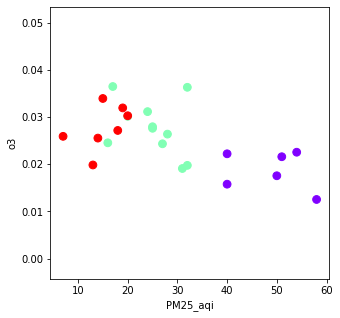

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(AQI_table['PM25_aqi'], AQI_table['o3'], s=60, c=y, cmap='rainbow')
plt.xlabel("PM25_aqi")
plt.ylabel("o3")
plt.show()

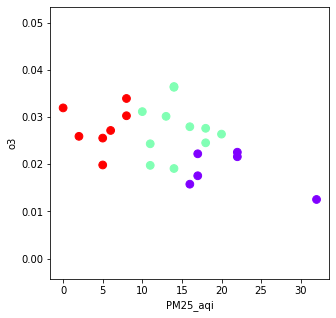

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(AQI_table['PM10_aqi'], AQI_table['o3'], s=60, c=y, cmap='rainbow')
plt.xlabel("PM25_aqi")
plt.ylabel("o3")
plt.show()

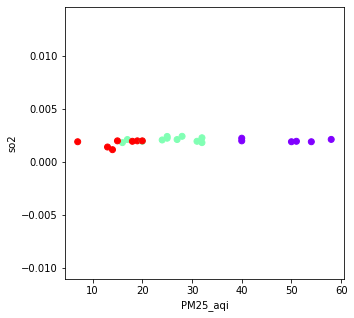

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(AQI_table['PM25_aqi'], AQI_table['so2'], c=y, cmap='rainbow')
plt.xlabel("PM25_aqi")
plt.ylabel("so2")
plt.show()

###GMM Clustering

In [18]:
gmm = GaussianMixture(n_components=3)
gmm.fit(AQI_table.iloc[:,1:].values)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(AQI_table.iloc[:,1:].values)
y_cluster_gmm


array([1, 2, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 2, 2, 1, 1,
       1, 2])

######Here both the K-means and GMM models same clusters

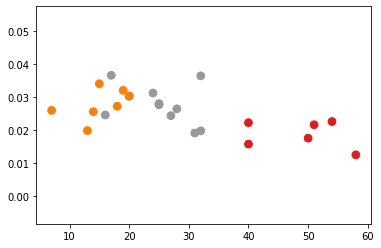

In [19]:
plt.scatter(AQI_table['PM25_aqi'], AQI_table['o3'], c=y_cluster_gmm, s=60, cmap='Set1');

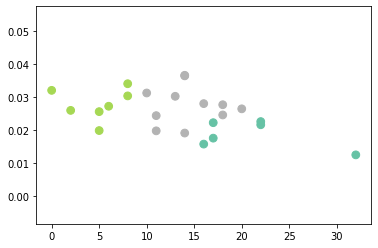

In [20]:
plt.scatter(AQI_table['PM10_aqi'], AQI_table['o3'], c=y_cluster_gmm, s=60, cmap='Set2');